In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Load the dataset
df = pd.read_csv('data/witcher.csv')

Witcher csv was downloaded from [kaggle](https://www.kaggle.com/datasets/avasadasivan/witcher-network). It's a small dataset that describes interaction between characters in the Witcher book series. The dataset contains ~~5~~ 4 columns: `Source`, `Target`, `Weight` and `book`. The `Source` and `Target` columns contain the names of the characters that interacted with each other. `Weight` column contains the number of interactions between the characters. The `book` column contains the book number in which the interaction took place.

For the sake of this experiment, we'll aim at classifying the interactions to the book they belong to. We'll use the `Source` and `Target` columns as features and the `book` column as the target variable. We'll use the `Weight` column as the edge weight between the characters.

This will then be transformed into embeddings using Cleora's algorithm and then used to train a classifier to predict the book number.

The dataset is small and the interactions are sparse, so we'll use a simple model to classify the interactions - most likely setting the baseline to a simple logistic regression model and possibly comparing it to some neural network model and RandomForestClassifier from sklearn.


In [2]:
print("First few rows of the dataset:")
display(df.head())

First few rows of the dataset:


,Unnamed: 0,Source,Target,Type,Weight,book
0,0,Velerad,Geralt,Undirected,1,1
1,1,Geralt,Foltest,Undirected,5,1
2,2,Foltest,Geralt,Undirected,4,1
3,3,Adda,Geralt,Undirected,1,1
4,4,Geralt,Ostrit,Undirected,4,1


In [3]:
df['Type'].value_counts()

# only one value for 'Type' column, so we can drop it
df.drop('Type', axis=1, inplace=True)

# Unnamed: 0 is just an index, so we can drop it as well
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
print("\nSummary Statistics:")
display(df.describe())


Summary Statistics:


,Weight,book
count,2600.000000,2600.000000
mean,3.280385,4.652692
std,6.241843,1.958533
min,1.000000,1.000000
25%,1.000000,3.000000
50%,1.000000,5.000000
75%,3.000000,7.000000
max,88.000000,7.000000


In [5]:
# No missing values present
print("\nMissing Values:")
display(df.isnull().sum())



Missing Values:


Source    0
Target    0
Weight    0
book      0
dtype: int64

In [6]:
# no duplicate rows in the data neither
print("\nNumber of Duplicate Rows:")
display(df.duplicated().sum())


Number of Duplicate Rows:


np.int64(0)


Distribution of Weight(interaction counts) Features:


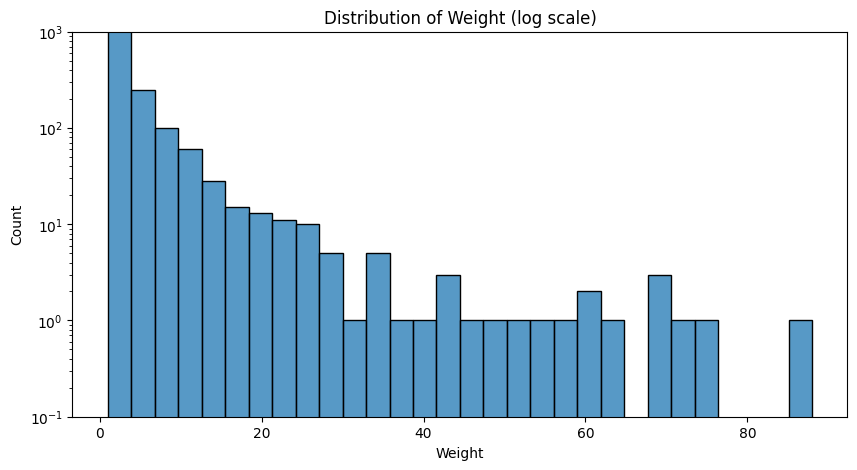


Distribution of Book number:


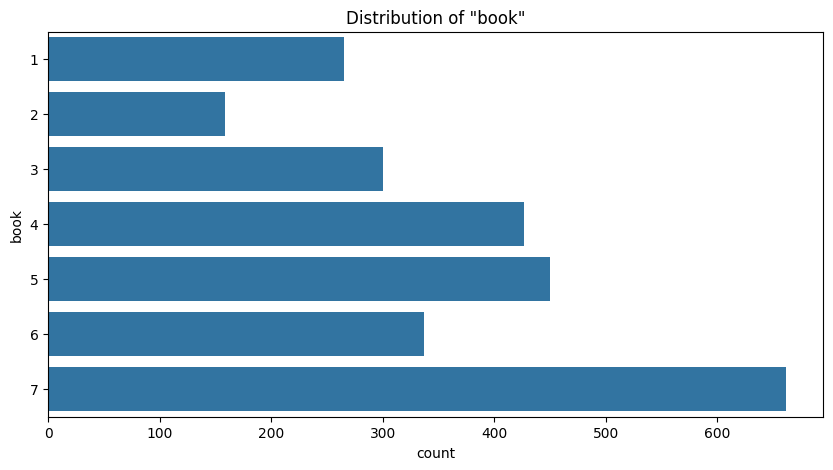

In [7]:
# Display the distribution of numerical features, Weight on log scale
print("\nDistribution of Weight(interaction counts) Features:")

plt.figure(figsize=(10, 5))
sns.histplot(df['Weight'], bins=30, kde=False)
plt.title(f'Distribution of Weight (log scale)')
plt.yscale('log')
plt.ylim(0.1, 1000)
plt.show()


print("\nDistribution of Book number:")
plt.figure(figsize=(10, 5))
sns.countplot(y="book", data=df)
plt.title(f'Distribution of "book"')
plt.show()



Pairplot of Numerical Features:


<Figure size 1000x1000 with 0 Axes>

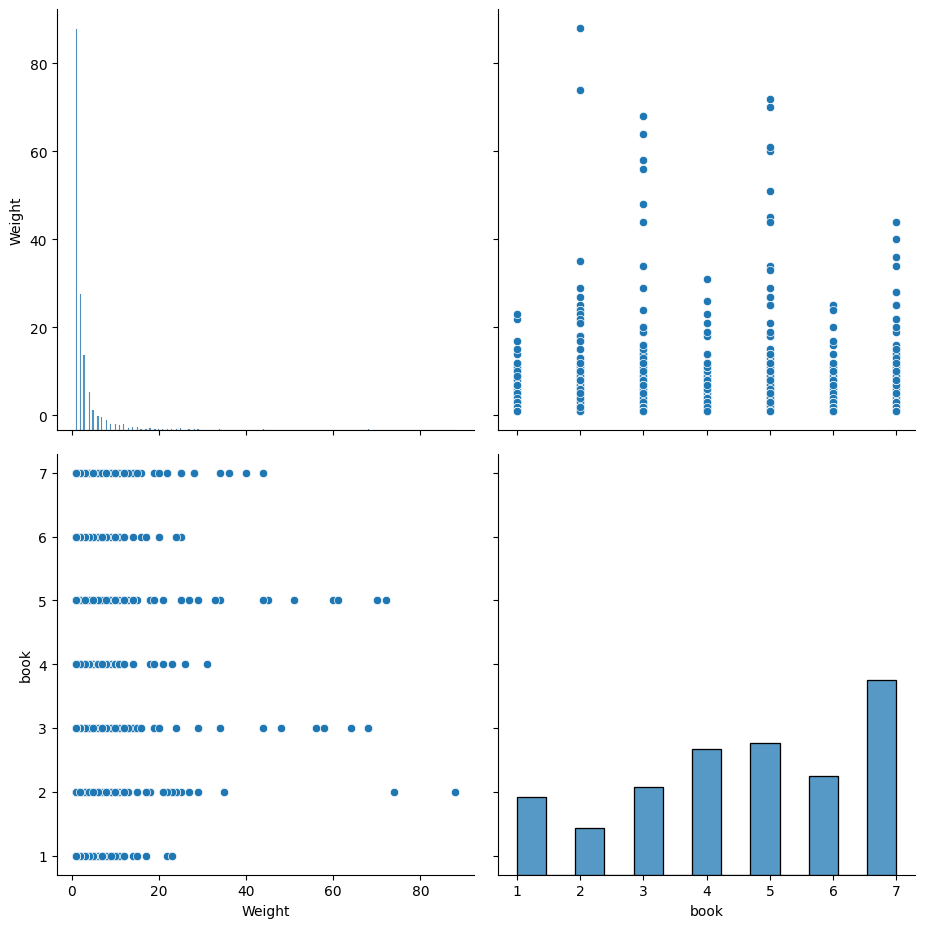

In [8]:
print("\nPairplot of Numerical Features:")
warnings.filterwarnings('ignore')
plt.figure(figsize=(10, 10))
fig = sns.pairplot(df)
fig.fig.set_size_inches(10, 10)

\Violin plot of Numerical Features:


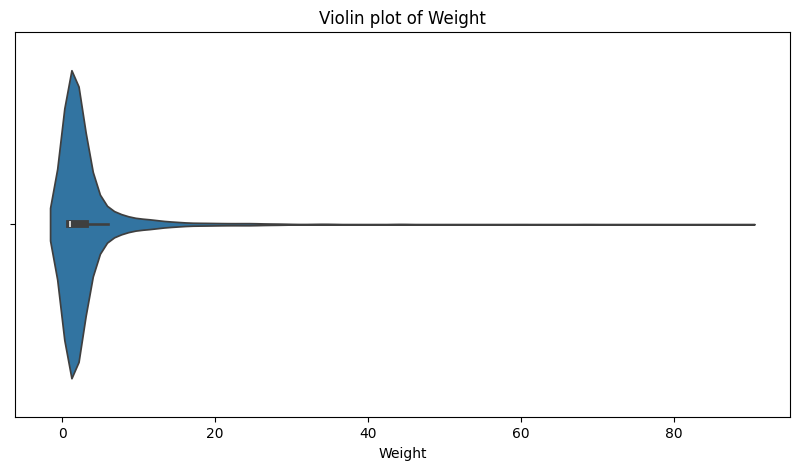

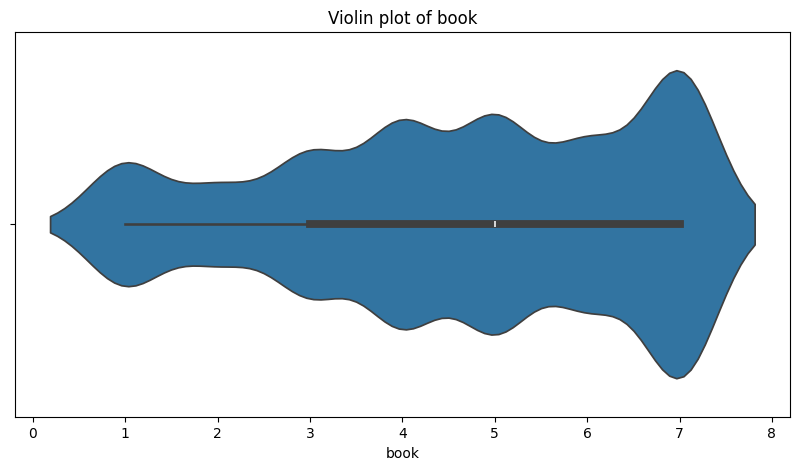

In [9]:

# Boxplots for numerical features to check for outliers
print("\Violin plot of Numerical Features:")
numerical_features = df.select_dtypes(include=[np.number]).columns
for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.violinplot(x=df[feature])
    plt.title(f'Violin plot of {feature}')
    plt.show()

In [10]:
%pip install netgraph

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\Uni\cleora-social-network\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
import networkx as nx
import plotly.graph_objects as go
import matplotlib.colors as mcolors

# Create the graph
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

# Set node positions
pos = nx.spring_layout(G, k=0.3)

node_degrees = dict(G.degree())
max_degree = max(node_degrees.values())
node_colors = [255 - (degree / max_degree * 255) for degree in node_degrees.values()]
node_sizes = [5 + (degree / max_degree * 20) for degree in node_degrees.values()]

# Define a custom colormap from light blue to red
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["lightgreen", "red"])
norm = mcolors.Normalize(vmin=min(nx.get_edge_attributes(G, 'weight').values()),
                         vmax=max(nx.get_edge_attributes(G, 'weight').values()))

# Create edge traces with custom colors
edge_traces = []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    weight = edge[2]['weight']
    rgba_color = mcolors.to_rgba(custom_cmap(norm(weight)), alpha=0.5)
    color = f'rgba({rgba_color[0] * 255}, {rgba_color[1] * 255}, {rgba_color[2] * 255}, {rgba_color[3]})'

    edge_trace = go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        line=dict(width=0.5, color=color),
        hoverinfo='none',
        mode='lines'
    )
    edge_traces.append(edge_trace)

# Create node traces
node_x, node_y = zip(*[pos[node] for node in G.nodes()])
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    text=[f'Node: {node}<br>Degree: {degree}' for node, degree in node_degrees.items()],
    marker=dict(
        showscale=False,
        colorscale='Blues',
        color=node_colors,
        size=node_sizes,
        colorbar=dict(
            thickness=15,
            title='Node Degree',
            xanchor='left',
            titleside='right'
        ),
        line_width=1,
        line_color='DarkSlateGrey'))

# Combine edge and node traces
fig = go.Figure(data=edge_traces + [node_trace],
                layout=go.Layout(
                    title='<b>Global Network Graph Edges</b>',
                    title_x=0.5,
                    titlefont=dict(size=24, color='DarkSlateGrey'),
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=40),
                    annotations=[
                        dict(
                            showarrow=False,
                            text="Nodes are sized and colored based on their degree; edges colored by weight",
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002,
                            xanchor='left', yanchor='bottom',
                            font=dict(size=12)
                        )
                    ],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    width=1000,
                    height=1000
                ))

fig.show()


In [12]:
# save processed data to .tsv file
book = df['book']
df.drop('book', axis=1, inplace=True)


In [14]:
df

,Source,Target,Weight
0,Velerad,Geralt,1
1,Geralt,Foltest,5
2,Foltest,Geralt,4
3,Adda,Geralt,1
4,Geralt,Ostrit,4
...,...,...,...
2595,Lytta,Ciri,2
2596,Lytta,Triss,1
2597,Triss,Dandelion,1
2598,Triss,Yarpen,1


In [15]:
df.to_csv('data/witcher_processed.tsv', sep='\t', index=False)

In [16]:
book.to_csv('data/witcher_target.tsv', sep='\t', index=False)